# Processing the windows
This notebook focusses on the processing of the sampled windows, to prepare them to be used as training and test data in the modelling part. At this point it only involves checking how many participants are still included in the windows DataFrames and adding the age and gender information to all the windows. More processing steps, could be added to this notebook.
#### Requirements
If one wants to run this notebook, make sure that you have run the `4-ak-window-sampling` notebook. This notebook is responsible for processing the windows DataFrames, stored in `data\processed`, created by this previous notebook.
You also need to have stored the demographics file `Demogr tDCS WM stress.csv` in the `data\raw` directory.

In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
Mitchel = False

After loading in the required modules, we store the working directory in a variable called `project_dir`. We then store the folder where the data files are located in a variable called `data_dir`. We also store the specific processed directory and processed files in specific directories.

In [3]:
project_dir = os.getcwd().split('\\')[:-1]
project_dir = '\\'.join(project_dir) # Get the project dir 
# Get the data dir
if Mitchel:
    data_dir = 'C:\\Users\\mitch\\OneDrive - UGent\\UGent\\Projects\\7. tDCS_Stress_WM_deSmet\\data'
    data_dir = 'Z:\\ghep_lab\\2020_DeSmetKappen_tDCS_Stress_WM_VIDEO\\Data'
else: 
    data_dir = project_dir + '\\data'
processed_dir = data_dir + '\\processed' # Get the processed subdir
processed_files = [file for file in os.listdir(processed_dir) if file.endswith('feather') and not file.startswith('processed_') and not file.startswith('RESULTS')] # Get the processed files

## Processing
Below we execute some simple processing steps, if necessary more can be added below.
### Outlier removal
Below we remove the segments that have an outlying value in of the two target variables. This is executed for both data files and then written back to the original feather file.

In [4]:
from scipy import stats
def remove_outliers(data, targets):
    return data[(np.abs(stats.zscore(data[targets])) < 3).all(axis=1)]

for file in processed_files:
    window = pd.read_feather(f'{processed_dir}\\{file}')
    before = len(window.index)
    window = remove_outliers(window, ['standardised_mean_scl', 'HRV_SDNN_corrected'])
    after = len(window.index)
    print(f'Removed {before-after} segments from {file}')
    window.reset_index(inplace=True, drop=True)
    window.to_feather(f'{processed_dir}\\processed_{file}')

Removed 4 segments from window_180_step_180.feather
Removed 0 segments from window_300_step_300.feather


### Checking how many participants were still in the data sample
We noticed that we did not extract data from all participants. The first cell shows from how many participants windows were present in the different DataFrames.

In [5]:
for file in processed_files:
    window = pd.read_feather(f'{processed_dir}\\{file}')
    print(f'In file {file} there is data from {len(window.pp.unique())} participants')

In file window_180_step_180.feather there is data from 60 participants
In file window_300_step_300.feather there is data from 54 participants


### Gender & Age
In the next two cells we add the age and gender of the participant to each processed window. We get the age and gender from the demographics file `Demogr tDCS WM stress.csv`. We also applied a quick fix since some rows did not separate properly. In the second cell we loop over the DataFrames, adding the gender and age.

In [6]:
demogr = pd.read_csv(data_dir + '\\raw\\Demogr tDCS WM stress.csv', sep=',') # Reading in the demographics DataFrame

## Handling the rows that did not separatly properly
i = demogr[demogr.id.str.split(',').str.len()>2].index ## Finding the rows that did not seperate by checking if they now do split
demogr.loc[i, 'geboortedatum_patient'] = demogr.loc[i, 'id'].str.split(',').str[1] # Extracting the birth date, and adding this to the column geboortedatum_patient
demogr.loc[i, 'geslacht'] = demogr.loc[i, 'id'].str.split(',').str[2] # Extracting the gender, and adding this to the column geslacht
demogr.loc[i, 'id'] = demogr.loc[i, 'id'].str.split(',').str[0] # Extracting the id, and adding this to the column id

demogr = demogr[['id', 'geboortedatum_patient', 'geslacht']] # Dropping all the other columns from the DataFrame
demogr['geboortedatum_patient'] = pd.to_datetime(demogr['geboortedatum_patient']) # Setting the birth date column as a datetime object
now = pd.Timestamp('now') # Getting the current time
demogr['leeftijd'] = (now - demogr['geboortedatum_patient']).astype('<m8[Y]') # Subtracting the birth dates from the current time to get the age of the participant in years.
demogr[['id']] = demogr[['id']].astype('str')
demogr[['geslacht']] = demogr[['geslacht']].astype('int')
demogr[['leeftijd']] = demogr[['leeftijd']].astype('int')

In [7]:
demogr.id = demogr.id.str.split(',').str[0].astype('int64') # Setting the id of the participant as int type (necessary to merge on pp id)

for file in processed_files: # For each windows DataFrame
    window = pd.read_feather(f'{processed_dir}\\processed_{file}') # Read in the windows DataFrame
    window.pp = window.pp.astype('int64') # Set pp id as int type
    df = window.merge(demogr[['id', 'geslacht', 'leeftijd']], how='left', left_on='pp', right_on='id', validate='many_to_one') # Adding the age and gender of each participant (merging on pp_id)
    df.to_feather(f'{processed_dir}\\processed_{file}') # Saving the DataFrame in the processed dir with the prefix "processed_"

### Visualisation
The cell below is responsible for creating the graphs that are presented in the results section of the final paper.import matplotlib.pyplot as plt

In [8]:
window = pd.read_feather(f'{processed_dir}\\processed_window_180_step_180.feather')

In [9]:
import matplotlib.pyplot as plt

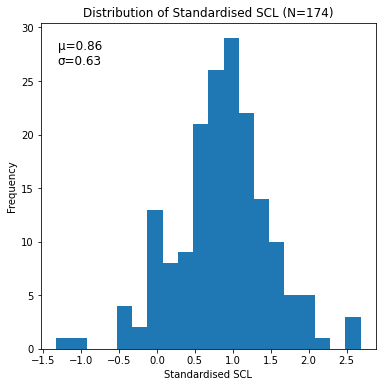

In [10]:
fig, ax = plt.subplots(figsize=(6,6))
target = 'Standardised SCL'
ax.hist(window['standardised_mean_scl'], bins=20)
ax.set_title(f'Distribution of {target} (N={len(window["standardised_mean_scl"])})')
ax.set_xlabel(target)
ax.set_ylabel('Frequency')
textstr = f'\u03BC={window["standardised_mean_scl"].mean():.2f}\n\u03C3={window["standardised_mean_scl"].std():.2f}'
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12, verticalalignment='top')
plt.savefig(f'{project_dir}\\reports\\figures\\distribution_{target}.jpg')

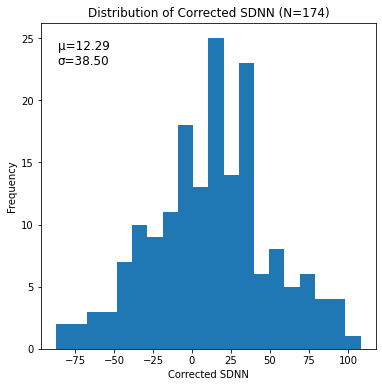

In [11]:
fig, ax = plt.subplots(figsize=(6,6))
target = 'Corrected SDNN'
ax.hist(window['HRV_SDNN_corrected'], bins=20)
ax.set_title(f'Distribution of {target} (N={len(window["HRV_SDNN_corrected"])})')
ax.set_xlabel(target)
ax.set_ylabel('Frequency')
textstr = f'\u03BC={window["HRV_SDNN_corrected"].mean():.2f}\n\u03C3={window["HRV_SDNN_corrected"].std():.2f}'
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12, verticalalignment='top')
plt.savefig(f'{project_dir}\\reports\\figures\\distribution_{target}.jpg')